## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [3]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [4]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [5]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

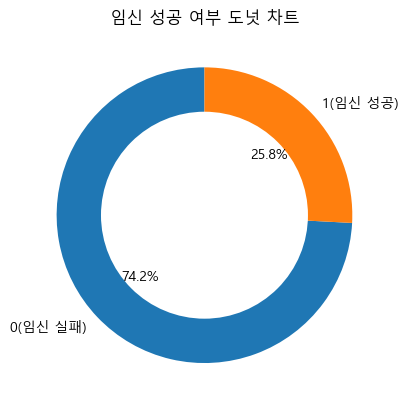

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [7]:
# '시술_시기_코드' 변수의 값이 'TRJXFG'에 해당 안하는 데이터 추출
IVF_train = train[train['시술_시기_코드'] == 'TRJXFG'] 
IVF_test = test[test['시술_시기_코드'] == 'TRJXFG']

# 모든 값이 결측값인 변수를 제거
IVF_train = IVF_train.dropna(axis=1, how='all')
IVF_test = IVF_test.dropna(axis=1, how='all')

train = IVF_train
test = IVF_test

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [8]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
TRJXFG    0.733729  0.266271  26437  9594  36031


In [9]:
# '시술_시기_코드' 변수 제거
train = train.drop(columns=['시술_시기_코드'])
test = test.drop(columns=['시술_시기_코드'])

### 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [10]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
만18-34세   0.675224  0.324776  9969.0  4795.0  14764
만35-37세   0.709008  0.290992  5604.0  2300.0   7904
만38-39세   0.772436  0.227564  4226.0  1245.0   5471
만40-42세   0.835361  0.164639  4394.0   866.0   5260
만43-44세   0.875155  0.124845  1409.0   201.0   1610
만45-50세   0.805613  0.194387   775.0   187.0    962
알 수 없음    1.000000  0.000000    60.0     0.0     60


In [11]:
test['시술_당시_나이'].value_counts()

만18-34세    5324
만35-37세    2791
만38-39세    1926
만40-42세    1813
만43-44세     562
만45-50세     333
알 수 없음       15
Name: 시술_당시_나이, dtype: int64

### 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [12]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0.0       0.500000  0.500000   1.0   1.0      2
1.0       1.000000  0.000000   2.0   0.0      2
3.0       0.666667  0.333333   2.0   1.0      3
4.0       0.500000  0.500000   2.0   2.0      4
5.0       1.000000  0.000000   3.0   0.0      3
6.0       0.882353  0.117647  15.0   2.0     17
7.0       0.750000  0.250000  30.0  10.0     40
8.0       0.760417  0.239583  73.0  23.0     96
9.0       0.721649  0.278351  70.0  27.0     97
10.0      0.656566  0.343434  65.0  34.0     99
11.0      0.809524  0.190476  68.0  16.0     84
12.0      0.733333  0.266667  33.0  12.0     45
13.0      0.878788  0.121212  58.0   8.0     66
14.0      0.800000  0.200000  32.0   8.0     40
15.0      0.800000  0.200000  24.0   6.0     30
16.0      0.920000  0.080000  23.0   2.0     25
17.0      0.826087  0.173913  19.0   4.0     23
18.0      0.750000  0.250000   9.0   3.0     1

In [13]:
# 3년 단위로 범주화
bins = list(range(0, 24, 3))  # 0부터 20까지 3년 단위로 구간 생성
labels = [f'{i}-{i+2}년' for i in range(0, 21, 3)]  # 범주 레이블 생성

train['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(train['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)
test['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(test['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)

# 결측값을 'unknown'으로 채우기 위해 범주에 'unknown' 추가
train['임신_시도_또는_마지막_임신_경과_연수'] = train['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])
test['임신_시도_또는_마지막_임신_경과_연수'] = test['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])

train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

In [14]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0-2년      0.750000  0.250000      3     1      4
3-5년      0.700000  0.300000      7     3     10
6-8년      0.771242  0.228758    118    35    153
9-11년     0.725000  0.275000    203    77    280
12-14년    0.814570  0.185430    123    28    151
15-17년    0.846154  0.153846     66    12     78
18-20년    0.777778  0.222222     21     6     27
unknown   0.733016  0.266984  25896  9432  35328


### 4. 시술_유형

IVF 또는 DI 시술 여부

In [15]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
DI        0.886770  0.113230    744    95    839
IVF       0.730081  0.269919  25693  9499  35192


In [16]:
test['시술_유형'].value_counts()

IVF    12437
DI       327
Name: 시술_유형, dtype: int64

### 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [17]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                 group  '임신_성공_여부' count     ratio  Total
0           Generic DI                 2  0.285714      7
1                  ICI                 1  0.250000      4
2                 ICSI              4973  0.283443  17545
3            ICSI / AH                 3  0.250000     12
4   ICSI / BLASTOCYST                 11  0.268293     41
5            ICSI:ICSI                 0  0.000000    194
6             ICSI:IVF                35  0.291667    120
7         ICSI:Unknown                 7  0.250000     28
8                  IUI                92  0.111245    827
9                  IVF              3579  0.267669  13371
10            IVF / AH                 3  0.600000      5
11    IVF / BLASTOCYST                 8  0.216216     37
12            IVF:ICSI                14  0.254545     55
13             IVF:IVF                 2  0.013333    150
14         IVF:Unknown                 1  0.125000      8
15                 IVI                 0  0.000000

In [18]:
test['특정_시술_유형'].value_counts()

ICSI                  6297
IVF                   4664
Unknown               1270
IUI                    325
ICSI:ICSI               66
IVF:IVF                 45
ICSI:IVF                34
IVF:ICSI                20
IVF / BLASTOCYST        15
ICSI / BLASTOCYST       14
ICSI:Unknown             6
ICSI / AH                4
IVF:Unknown              2
Generic DI               2
Name: 특정_시술_유형, dtype: int64

In [19]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
# test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [20]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
        elif treatment == "IUI:ICI":
            return "IUI"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [21]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1        0       1  Total
variable                                                     
Generic DI         0.714286  0.285714      5.0     2.0      7
ICI                0.750000  0.250000      3.0     1.0      4
ICSI               0.719629  0.280371  12872.0  5015.0  17887
ICSI / AH          0.750000  0.250000      9.0     3.0     12
ICSI / BLASTOCYST  0.731707  0.268293     30.0    11.0     41
IUI                0.888755  0.111245    735.0    92.0    827
IVF                0.735277  0.264723   9988.0  3596.0  13584
IVF / AH           0.400000  0.600000      2.0     3.0      5
IVF / BLASTOCYST   0.783784  0.216216     29.0     8.0     37
IVI                1.000000  0.000000      1.0     0.0      1
Unknown            0.761931  0.238069   2762.0   863.0   3625


In [22]:
test['변환된_특정_시술_유형'].value_counts()

ICSI                 6403
IVF                  4731
Unknown              1270
IUI                   325
IVF / BLASTOCYST       15
ICSI / BLASTOCYST      14
ICSI / AH               4
Generic DI              2
Name: 변환된_특정_시술_유형, dtype: int64

In [23]:
# 더미 변수 생성 함수 정의
def create_dummy(x, keyword):
    if isinstance(x, str) and keyword in x:
        return 1
    else:
        return 0

# 더미 변수 생성
train['특정_시술_유형_ICSI_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
train['특정_시술_유형_IVF_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
train['특정_시술_유형_AH_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
train['특정_시술_유형_BLASTOCYST_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

test['특정_시술_유형_ICSI_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
test['특정_시술_유형_IVF_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
test['특정_시술_유형_AH_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
test['특정_시술_유형_BLASTOCYST_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

In [24]:
summarize_group(train, ['특정_시술_유형',
                        '특정_시술_유형_ICSI_더미',
                          '특정_시술_유형_IVF_더미',
                            '특정_시술_유형_AH_더미',
                              '특정_시술_유형_BLASTOCYST_더미'])

Grouped by: 특정_시술_유형, 특정_시술_유형_ICSI_더미, 특정_시술_유형_IVF_더미, 특정_시술_유형_AH_더미, 특정_시술_유형_BLASTOCYST_더미

                               group  '임신_성공_여부' count     ratio  Total
0           (Generic DI, 0, 0, 0, 0)                 2  0.285714      7
1                  (ICI, 0, 0, 0, 0)                 1  0.250000      4
2                 (ICSI, 1, 0, 0, 0)              4973  0.283443  17545
3            (ICSI / AH, 1, 0, 1, 0)                 3  0.250000     12
4   (ICSI / BLASTOCYST , 1, 0, 0, 1)                11  0.268293     41
5            (ICSI:ICSI, 1, 0, 0, 0)                 0  0.000000    194
6             (ICSI:IVF, 1, 0, 0, 0)                35  0.291667    120
7         (ICSI:Unknown, 1, 0, 0, 0)                 7  0.250000     28
8                  (IUI, 0, 0, 0, 0)                92  0.111245    827
9                  (IVF, 0, 1, 0, 0)              3579  0.267669  13371
10            (IVF / AH, 0, 1, 1, 0)                 3  0.600000      5
11    (IVF / BLASTOCYST, 0, 1, 0, 1)   

In [25]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

### 6. 배란_자극_여부

배란 자극 치료가 사용되었는지 여부

In [26]:
value_counts_ratio(train, '배란_자극_여부')


배란_자극_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.759543  0.240457   6188  1959   8147
1         0.726187  0.273813  20249  7635  27884


### 7. 배란_유도_유형

사용된 배란 유도 방법 유형

In [27]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                   0         1      0     1  Total
variable                                          
기록되지 않은 시행  0.723747  0.276253  19856  7579  27435
알 수 없음      0.765589  0.234411   6581  2015   8596


In [28]:
test['배란_유도_유형'].value_counts()

기록되지 않은 시행    9715
알 수 없음        3049
Name: 배란_유도_유형, dtype: int64

### 8. 단일_배아_이식_여부

선택적으로 단일 배아를 이식했는지 여부

In [29]:
value_counts_ratio(train, '단일_배아_이식_여부')


단일_배아_이식_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.762939  0.237061  20063  6234  26297
1.0       0.632940  0.367060   5630  3265   8895


### 9. 착상_전_유전_검사_사용_여부

PGS(착상 전 유전 검사)가 시행되었는지 여부

In [30]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.782787  0.217213  191  53    244


In [31]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)
test['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

결측값 개수: 35787
결측값 개수: 0


In [32]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.733395  0.266605  26246  9541  35787
1.0       0.782787  0.217213    191    53    244


### 10. 착상_전_유전_진단_사용_여부

PGD(착상 전 유전 진단)가 시행되었는지 여부

In [33]:
value_counts_ratio(train, '착상_전_유전_진단_사용_여부')


착상_전_유전_진단_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.729810  0.270190  25366  9391  34757
1.0       0.751724  0.248276    327   108    435


In [34]:
summarize_group(train, ['착상_전_유전_진단_사용_여부', '착상_전_유전_검사_사용_여부'])

Grouped by: 착상_전_유전_진단_사용_여부, 착상_전_유전_검사_사용_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              9338  0.270557  34514
1  (0.0, 1.0)                53  0.218107    243
2  (1.0, 0.0)               108  0.248848    434
3  (1.0, 1.0)                 0  0.000000      1


### 11. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [35]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733166  0.266834  26012  9467  35479
1         0.769928  0.230072    425   127    552


### 12. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [36]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733454  0.266546  26232  9533  35765
1         0.770677  0.229323    205    61    266


In [37]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9406  0.267117  35213
1  (0, 1)                61  0.229323    266
2  (1, 0)               127  0.230072    552


### 13. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [38]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733252  0.266748  25974  9449  35423
1         0.761513  0.238487    463   145    608


### 14. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [39]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733283  0.266717  26242  9545  35787
1         0.799180  0.200820    195    49    244


In [40]:
summarize_group(train, ['여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 여성_주_불임_원인, 여성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9401  0.267226  35180
1  (0, 1)                48  0.197531    243
2  (1, 0)               144  0.237232    607
3  (1, 1)                 1  1.000000      1


In [41]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인

          group  '임신_성공_여부' count     ratio  Total
0  (0, 0, 0, 0)              9401  0.267241  35178
1  (0, 0, 0, 1)                 0  0.000000      5
2  (0, 0, 1, 0)                 5  0.166667     30
3  (0, 1, 0, 0)                 0  0.000000      1
4  (0, 1, 0, 1)                40  0.225989    177
5  (0, 1, 1, 0)                21  0.238636     88
6  (1, 0, 0, 0)                 0  0.000000      1
7  (1, 0, 0, 1)                 8  0.131148     61
8  (1, 0, 1, 0)               118  0.241309    489
9  (1, 0, 1, 1)                 1  1.000000      1


### 15. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [42]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733055  0.266945  25945  9448  35393
1         0.771160  0.228840    492   146    638


### 16. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [43]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733525  0.266475  26302  9555  35857
1         0.775862  0.224138    135    39    174


In [44]:
summarize_group(train, ['부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 부부_주_불임_원인, 부부_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9409  0.267157  35219
1  (0, 1)                39  0.224138    174
2  (1, 0)               146  0.228840    638


In [45]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'
                        , '여성_주_불임_원인', '여성_부_불임_원인'
                        , '부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인, 부부_주_불임_원인, 부부_부_불임_원인

                 group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0, 0, 0)              9401  0.267256  35176
1   (0, 0, 0, 0, 0, 1)                 0  0.000000      2
2   (0, 0, 0, 1, 0, 0)                 0  0.000000      4
3   (0, 0, 0, 1, 0, 1)                 0  0.000000      1
4   (0, 0, 1, 0, 0, 0)                 5  0.178571     28
5   (0, 0, 1, 0, 1, 0)                 0  0.000000      2
6   (0, 1, 0, 0, 0, 0)                 0  0.000000      1
7   (0, 1, 0, 1, 0, 0)                 2  0.666667      3
8   (0, 1, 0, 1, 0, 1)                32  0.219178    146
9   (0, 1, 0, 1, 1, 0)                 6  0.214286     28
10  (0, 1, 1, 0, 0, 1)                 7  0.318182     22
11  (0, 1, 1, 0, 1, 0)                14  0.212121     66
12  (1, 0, 0, 0, 1, 0)                 0  0.000000      1
13  (1, 0, 0, 1, 0, 1)                 0  0.000000      3
14  (1, 0, 0, 1, 1, 0)                 8  0.13

### 17. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [46]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.732570  0.267430  19953  7284  27237
1         0.737321  0.262679   6484  2310   8794


### 18. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [47]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733533  0.266467  22730  8257  30987
1         0.734933  0.265067   3707  1337   5044


### 19. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [48]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.747849  0.252151  17033  5743  22776
1         0.709468  0.290532   9404  3851  13255


### 20. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [49]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.738425  0.261575  22999  8147  31146
1         0.703787  0.296213   3438  1447   4885


### 21. 불임_원인_-_여성_요인

여성 요인으로 인한 불임 여부

In [50]:
value_counts_ratio(train, '불임_원인_-_여성_요인')


불임_원인_-_여성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733729  0.266271  26437  9594  36031


In [51]:
test['불임_원인_-_여성_요인'].value_counts()

0    12764
Name: 불임_원인_-_여성_요인, dtype: int64

In [52]:
# '불임_원인_-_여성_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_여성_요인'])
test = test.drop(columns=['불임_원인_-_여성_요인'])

### 22. 불임_원인_-_자궁경부_문제

자궁경부 이상으로 인한 불임 여부

In [53]:
value_counts_ratio(train, '불임_원인_-_자궁경부_문제')


불임_원인_-_자궁경부_문제별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.733722  0.266278  26436.0  9594.0  36030
1         1.000000  0.000000      1.0     0.0      1


### 23. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [54]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733966  0.266034  24502  8881  33383
1         0.730740  0.269260   1935   713   2648


### 24. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [55]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733717  0.266283  26416  9587  36003
1         0.750000  0.250000     21     7     28


### 25. 불임_원인_-_정자_면역학적_요인

파트너의 정자 면역 관련 문제 여부

In [56]:
value_counts_ratio(train, '불임_원인_-_정자_면역학적_요인')


불임_원인_-_정자_면역학적_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733729  0.266271  26437  9594  36031


In [57]:
test['불임_원인_-_정자_면역학적_요인'].value_counts()

0    12764
Name: 불임_원인_-_정자_면역학적_요인, dtype: int64

In [58]:
# '불임_원인_-_정자_면역학적_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_면역학적_요인'])
test = test.drop(columns=['불임_원인_-_정자_면역학적_요인'])

### 26. 불임_원인_-_정자_운동성

파트너의 정자 운동성 문제 여부

In [59]:
value_counts_ratio(train, '불임_원인_-_정자_운동성')


불임_원인_-_정자_운동성별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733735  0.266265  26435  9593  36028
1         0.666667  0.333333      2     1      3


In [60]:
# '불임_원인_-_정자_운동성' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_운동성'])
test = test.drop(columns=['불임_원인_-_정자_운동성'])

### 27. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [61]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733716  0.266284  26427  9591  36018
1         0.769231  0.230769     10     3     13


### 28. 배아_생성_주요_이유

배아 생성의 주된 목적(시술, 보관 등)

In [62]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    171.0     0.0    171
기증용, 난자 저장용          1.000000  0.000000      5.0     0.0      5
기증용, 배아 저장용          1.000000  0.000000     12.0     0.0     12
기증용, 배아 저장용, 현재 시술용  1.000000  0.000000      3.0     0.0      3
기증용, 현재 시술용          0.607207  0.392793    337.0   218.0    555
난자 저장용               1.000000  0.000000    245.0     0.0    245
난자 저장용, 배아 저장용       1.000000  0.000000      2.0     0.0      2
배아 저장용               1.000000  0.000000    599.0     0.0    599
배아 저장용, 현재 시술용       0.500000  0.500000      1.0     1.0      2
현재 시술용               0.723793  0.276207  24318.0  9280.0  33598


In [63]:
# '연구용'이라는 값이 포함된 행 삭제
train = train[~train['배아_생성_주요_이유'].str.contains('연구용', na=False)]
# test = test[~test['배아_생성_주요_이유'].str.contains('연구용', na=False)]

In [64]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    171.0     0.0    171
기증용, 난자 저장용          1.000000  0.000000      5.0     0.0      5
기증용, 배아 저장용          1.000000  0.000000     12.0     0.0     12
기증용, 배아 저장용, 현재 시술용  1.000000  0.000000      3.0     0.0      3
기증용, 현재 시술용          0.607207  0.392793    337.0   218.0    555
난자 저장용               1.000000  0.000000    245.0     0.0    245
난자 저장용, 배아 저장용       1.000000  0.000000      2.0     0.0      2
배아 저장용               1.000000  0.000000    599.0     0.0    599
배아 저장용, 현재 시술용       0.500000  0.500000      1.0     1.0      2
현재 시술용               0.723793  0.276207  24318.0  9280.0  33598


In [65]:
test['배아_생성_주요_이유'].value_counts()

현재 시술용                 11880
배아 저장용                   225
기증용, 현재 시술용              190
난자 저장용                    75
기증용                       61
기증용, 배아 저장용                3
기증용, 난자 저장용                2
기증용, 배아 저장용, 현재 시술용        1
Name: 배아_생성_주요_이유, dtype: int64

In [66]:
print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

train['배아_생성_주요_이유'].fillna('unknown', inplace=True)
test['배아_생성_주요_이유'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

결측값 개수: 839
결측값 개수: 0


In [67]:
# '현재 시술용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_현재시술용'] = train['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)
test['배아_생성_주요_이유_현재시술용'] = test['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)

In [68]:
# '기증용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_기증용'] = train['배아_생성_주요_이유'].str.contains('기증용').astype(int)
test['배아_생성_주요_이유_기증용'] = test['배아_생성_주요_이유'].str.contains('기증용').astype(int)

In [69]:
# '난자 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_난자저장용'] = train['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)
test['배아_생성_주요_이유_난자저장용'] = test['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)

In [70]:
# '배아 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_배아저장용'] = train['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)
test['배아_생성_주요_이유_배아저장용'] = test['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)

In [71]:
summarize_group(train, [
    # '배아_생성_주요_이유',
    '배아_생성_주요_이유_현재시술용',
    '배아_생성_주요_이유_기증용',
    '배아_생성_주요_이유_난자저장용',
    '배아_생성_주요_이유_배아저장용'
                        ])

Grouped by: 배아_생성_주요_이유_현재시술용, 배아_생성_주요_이유_기증용, 배아_생성_주요_이유_난자저장용, 배아_생성_주요_이유_배아저장용

           group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0)                95  0.113230    839
1   (0, 0, 0, 1)                 0  0.000000    599
2   (0, 0, 1, 0)                 0  0.000000    245
3   (0, 0, 1, 1)                 0  0.000000      2
4   (0, 1, 0, 0)                 0  0.000000    171
5   (0, 1, 0, 1)                 0  0.000000     12
6   (0, 1, 1, 0)                 0  0.000000      5
7   (1, 0, 0, 0)              9280  0.276207  33598
8   (1, 0, 0, 1)                 1  0.500000      2
9   (1, 1, 0, 0)               218  0.392793    555
10  (1, 1, 0, 1)                 0  0.000000      3


In [72]:
value_counts_ratio(train, '배아_생성_주요_이유_현재시술용')


배아_생성_주요_이유_현재시술용별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.949279  0.050721   1778    95   1873
1         0.721910  0.278090  24659  9499  34158


In [73]:
# # 변수 제거
# train = train.drop(columns=['배아_생성_주요_이유'])
# test = test.drop(columns=['배아_생성_주요_이유'])

### 29. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [74]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0회        0.707053  0.292947  9874  4091  13965
1회        0.742655  0.257345  5890  2041   7931
2회        0.738966  0.261034  3901  1378   5279
3회        0.745338  0.254662  2558   874   3432
4회        0.779605  0.220395  1659   469   2128
5회        0.781296  0.218704  1061   297   1358
6회 이상     0.770898  0.229102  1494   444   1938


In [75]:
test['총_시술_횟수'].value_counts()

0회       4910
1회       2942
2회       1896
3회       1130
4회        750
6회 이상     667
5회        469
Name: 총_시술_횟수, dtype: int64

In [76]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_시술_횟수'] = train['총_시술_횟수'].map(mapping)
test['총_시술_횟수'] = test['총_시술_횟수'].map(mapping)

value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0         0.707053  0.292947  9874  4091  13965
1         0.742655  0.257345  5890  2041   7931
2         0.738966  0.261034  3901  1378   5279
3         0.745338  0.254662  2558   874   3432
4         0.779605  0.220395  1659   469   2128
5         0.781296  0.218704  1061   297   1358
6         0.770898  0.229102  1494   444   1938


### 30. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [77]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.712060  0.287940  12340  4990  17330
1회        0.745892  0.254108   6264  2134   8398
2회        0.749683  0.250317   3546  1184   4730
3회        0.755896  0.244104   1923   621   2544
4회        0.783505  0.216495   1064   294   1358
5회        0.783602  0.216398    583   161    744
6회 이상     0.773463  0.226537    717   210    927


In [78]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['클리닉_내_총_시술_횟수'] = train['클리닉_내_총_시술_횟수'].map(mapping)
test['클리닉_내_총_시술_횟수'] = test['클리닉_내_총_시술_횟수'].map(mapping)

value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.712060  0.287940  12340  4990  17330
1         0.745892  0.254108   6264  2134   8398
2         0.749683  0.250317   3546  1184   4730
3         0.755896  0.244104   1923   621   2544
4         0.783505  0.216495   1064   294   1358
5         0.783602  0.216398    583   161    744
6         0.773463  0.226537    717   210    927


### 31. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [79]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.712905  0.287095  10551  4249  14800
1회        0.741698  0.258302   6053  2108   8161
2회        0.737919  0.262081   3894  1383   5277
3회        0.742822  0.257178   2432   842   3274
4회        0.771218  0.228782   1463   434   1897
5회        0.784062  0.215938    915   252   1167
6회 이상     0.775945  0.224055   1129   326   1455


In [80]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_시술_횟수'] = train['IVF_시술_횟수'].map(mapping)
test['IVF_시술_횟수'] = test['IVF_시술_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.712905  0.287095  10551  4249  14800
1         0.741698  0.258302   6053  2108   8161
2         0.737919  0.262081   3894  1383   5277
3         0.742822  0.257178   2432   842   3274
4         0.771218  0.228782   1463   434   1897
5         0.784062  0.215938    915   252   1167
6         0.775945  0.224055   1129   326   1455


### 32. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [81]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.730421  0.269579  24911  9194  34105
1회        0.818824  0.181176    348    77    425
2회        0.796020  0.203980    320    82    402
3회        0.794457  0.205543    344    89    433
4회        0.784861  0.215139    197    54    251
5회        0.804878  0.195122    132    32    164
6회 이상     0.737052  0.262948    185    66    251


In [82]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_시술_횟수'] = train['DI_시술_횟수'].map(mapping)
test['DI_시술_횟수'] = test['DI_시술_횟수'].map(mapping)

value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730421  0.269579  24911  9194  34105
1         0.818824  0.181176    348    77    425
2         0.796020  0.203980    320    82    402
3         0.794457  0.205543    344    89    433
4         0.784861  0.215139    197    54    251
5         0.804878  0.195122    132    32    164
6         0.737052  0.262948    185    66    251


### 33. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [83]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수



                 0         1      0     1  Total
variable                                        
0회        0.734108  0.265892  21168  7667  28835
1회        0.731370  0.268630   4544  1669   6213
2회        0.733880  0.266120    626   227    853
3회        0.750000  0.250000     90    30    120
4회        0.900000  0.100000      9     1     10


In [84]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_임신_횟수'] = train['총_임신_횟수'].map(mapping)
test['총_임신_횟수'] = test['총_임신_횟수'].map(mapping)

value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.734108  0.265892  21168  7667  28835
1         0.731370  0.268630   4544  1669   6213
2         0.733880  0.266120    626   227    853
3         0.750000  0.250000     90    30    120
4         0.900000  0.100000      9     1     10


### 34. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [85]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.735191  0.264809  21508  7747  29255
1회        0.725999  0.274001   4250  1604   5854
2회        0.732759  0.267241    595   217    812
3회        0.757282  0.242718     78    25    103
4회        0.857143  0.142857      6     1      7


In [86]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_임신_횟수'] = train['IVF_임신_횟수'].map(mapping)
test['IVF_임신_횟수'] = test['IVF_임신_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.735191  0.264809  21508  7747  29255
1         0.725999  0.274001   4250  1604   5854
2         0.732759  0.267241    595   217    812
3         0.757282  0.242718     78    25    103
4         0.857143  0.142857      6     1      7


### 35. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [87]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.732893  0.267107  26091.0  9509.0  35600
1회        0.806452  0.193548    300.0    72.0    372
2회        0.760870  0.239130     35.0    11.0     46
3회        0.833333  0.166667     10.0     2.0     12
4회        1.000000  0.000000      1.0     0.0      1


In [88]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_임신_횟수'] = train['DI_임신_횟수'].map(mapping)
test['DI_임신_횟수'] = test['DI_임신_횟수'].map(mapping)

value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.732893  0.267107  26091.0  9509.0  35600
1         0.806452  0.193548    300.0    72.0    372
2         0.760870  0.239130     35.0    11.0     46
3         0.833333  0.166667     10.0     2.0     12
4         1.000000  0.000000      1.0     0.0      1


### 36. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [89]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.734123  0.265877  22553  8168  30721
1회        0.731202  0.268798   3637  1337   4974
2회        0.734177  0.265823    232    84    316
3회        0.750000  0.250000     15     5     20


In [90]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_출산_횟수'] = train['총_출산_횟수'].map(mapping)
test['총_출산_횟수'] = test['총_출산_횟수'].map(mapping)

value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.734123  0.265877  22553  8168  30721
1         0.731202  0.268798   3637  1337   4974
2         0.734177  0.265823    232    84    316
3         0.750000  0.250000     15     5     20


### 37. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [91]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.734665  0.265335  22804  8236  31040
1회        0.727234  0.272766   3410  1279   4689
2회        0.740484  0.259516    214    75    289
3회        0.692308  0.307692      9     4     13


In [92]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['IVF_출산_횟수'] = train['IVF_출산_횟수'].map(mapping)
test['IVF_출산_횟수'] = test['IVF_출산_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.734665  0.265335  22804  8236  31040
1         0.727234  0.272766   3410  1279   4689
2         0.740484  0.259516    214    75    289
3         0.692308  0.307692      9     4     13


In [93]:
test['IVF_출산_횟수'].value_counts()

0    10979
1     1686
2       93
3        6
Name: IVF_출산_횟수, dtype: int64

### 38. DI_출산_횟수

DI 시술로 출산한 횟수

In [94]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.733302  0.266698  26184.0  9523.0  35707
1회        0.784247  0.215753    229.0    63.0    292
2회        0.714286  0.285714     20.0     8.0     28
3회        1.000000  0.000000      4.0     0.0      4


In [95]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_출산_횟수'] = train['DI_출산_횟수'].map(mapping)
test['DI_출산_횟수'] = test['DI_출산_횟수'].map(mapping)

value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.733302  0.266698  26184.0  9523.0  35707
1         0.784247  0.215753    229.0    63.0    292
2         0.714286  0.285714     20.0     8.0     28
3         1.000000  0.000000      4.0     0.0      4


In [96]:
test['DI_출산_횟수'].value_counts()

0    12667
1       93
2        4
Name: DI_출산_횟수, dtype: int64

In [97]:
# # 모든 행과 열을 다 보이게 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [98]:
# summarize_group(train, ['IVF_시술_횟수', 'IVF_임신_횟수', 'IVF_출산_횟수'])

In [99]:
# 주요 비율 계산 (train 데이터프레임)
train['IVF_임신_시술_비율'] = np.where(train['IVF_시술_횟수'] > 0, train['IVF_임신_횟수'] / train['IVF_시술_횟수'], 0)
train['IVF_출산_임신_비율'] = np.where(train['IVF_임신_횟수'] > 0, train['IVF_출산_횟수'] / train['IVF_임신_횟수'], 0)

train['DI_임신_시술_비율'] = np.where(train['DI_시술_횟수'] > 0, train['DI_임신_횟수'] / train['DI_시술_횟수'], 0)
train['DI_출산_임신_비율'] = np.where(train['DI_임신_횟수'] > 0, train['DI_출산_횟수'] / train['DI_임신_횟수'], 0)

# 성공률 계산
train['임신_성공률'] = np.where(train['총_시술_횟수'] > 0, train['총_임신_횟수'] / train['총_시술_횟수'], 0)
train['출산_성공률'] = np.where(train['총_임신_횟수'] > 0, train['총_출산_횟수'] / train['총_임신_횟수'], 0)

# 주요 비율 계산 (test 데이터프레임)
test['IVF_임신_시술_비율'] = np.where(test['IVF_시술_횟수'] > 0, test['IVF_임신_횟수'] / test['IVF_시술_횟수'], 0)
test['IVF_출산_임신_비율'] = np.where(test['IVF_임신_횟수'] > 0, test['IVF_출산_횟수'] / test['IVF_임신_횟수'], 0)

test['DI_임신_시술_비율'] = np.where(test['DI_시술_횟수'] > 0, test['DI_임신_횟수'] / test['DI_시술_횟수'], 0)
test['DI_출산_임신_비율'] = np.where(test['DI_임신_횟수'] > 0, test['DI_출산_횟수'] / test['DI_임신_횟수'], 0)

# 성공률 계산
test['임신_성공률'] = np.where(test['총_시술_횟수'] > 0, test['총_임신_횟수'] / test['총_시술_횟수'], 0)
test['출산_성공률'] = np.where(test['총_임신_횟수'] > 0, test['총_출산_횟수'] / test['총_임신_횟수'], 0)

### 39. 총_생성_배아_수

해당 시술에서 생성된 배아의 총 개수

In [100]:
value_counts_ratio(train, '총_생성_배아_수')


총_생성_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.828922  0.171078  6013.0  1241.0   7254
1.0       0.900500  0.099500  1801.0   199.0   2000
2.0       0.823155  0.176845  2197.0   472.0   2669
3.0       0.747069  0.252931  2230.0   755.0   2985
4.0       0.702079  0.297921  2161.0   917.0   3078
5.0       0.691830  0.308170  2007.0   894.0   2901
6.0       0.664190  0.335810  1788.0   904.0   2692
7.0       0.659374  0.340626  1537.0   794.0   2331
8.0       0.650590  0.349410  1268.0   681.0   1949
9.0       0.646263  0.353737  1003.0   549.0   1552
10.0      0.628592  0.371408   853.0   504.0   1357
11.0      0.618911  0.381089   648.0   399.0   1047
12.0      0.619458  0.380542   503.0   309.0    812
13.0      0.617600  0.382400   386.0   239.0    625
14.0      0.662309  0.337691   304.0   155.0    459
15.0      0.633136  0.366864   214.0   124.0    338
16.0      0.645695  0.354305   195

### 40. 미세주입된_난자_수

정자 미세주입(ICSI)으로 처리된 난자의 수

In [101]:
value_counts_ratio(train, '미세주입된_난자_수')


미세주입된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.745830  0.254170  13460.0  4587.0  18047
1.0       0.949550  0.050450    527.0    28.0    555
2.0       0.892025  0.107975    727.0    88.0    815
3.0       0.828408  0.171592    869.0   180.0   1049
4.0       0.763061  0.236939   1037.0   322.0   1359
5.0       0.724404  0.275596   1125.0   428.0   1553
6.0       0.712192  0.287808   1069.0   432.0   1501
7.0       0.672578  0.327422    986.0   480.0   1466
8.0       0.692478  0.307522    939.0   417.0   1356
9.0       0.674494  0.325506    833.0   402.0   1235
10.0      0.665785  0.334215    755.0   379.0   1134
11.0      0.635542  0.364458    633.0   363.0    996
12.0      0.648508  0.351492    500.0   271.0    771
13.0      0.628305  0.371695    404.0   239.0    643
14.0      0.657993  0.342007    354.0   184.0    538
15.0      0.665198  0.334802    302.0   152.0    454
16.0      0.646

### 41. 미세주입에서_생성된_배아_수

ICSI를 통해 생성된 배아의 수

In [102]:
value_counts_ratio(train, '미세주입에서_생성된_배아_수')


미세주입에서_생성된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.752921  0.247079  13984.0  4589.0  18573
1.0       0.900081  0.099919   1117.0   124.0   1241
2.0       0.820483  0.179517   1426.0   312.0   1738
3.0       0.747056  0.252944   1459.0   494.0   1953
4.0       0.698672  0.301328   1368.0   590.0   1958
5.0       0.680000  0.320000   1258.0   592.0   1850
6.0       0.648148  0.351852   1085.0   589.0   1674
7.0       0.659026  0.340974    920.0   476.0   1396
8.0       0.645018  0.354982    725.0   399.0   1124
9.0       0.653364  0.346636    573.0   304.0    877
10.0      0.615272  0.384728    419.0   262.0    681
11.0      0.603416  0.396584    318.0   209.0    527
12.0      0.625604  0.374396    259.0   155.0    414
13.0      0.630508  0.369492    186.0   109.0    295
14.0      0.636752  0.363248    149.0    85.0    234
15.0      0.668831  0.331169    103.0    51.0    154
16.0      

### 42. 이식된_배아_수

이식된 배아의 총 수

In [103]:
value_counts_ratio(train, '이식된_배아_수')


이식된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.998855  0.001145   4363     5   4368
1.0       0.684108  0.315892   9453  4365  13818
2.0       0.687096  0.312904  10830  4932  15762
3.0       0.841640  0.158360   1047   197   1244


### 43. 미세주입_배아_이식_수

ICSI 배아 중 이식된 배아의 수

In [104]:
value_counts_ratio(train, '미세주입_배아_이식_수')


미세주입_배아_이식_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.765710  0.234290  14622  4474  19096
1.0       0.674432  0.325568   4632  2236   6868
2.0       0.685028  0.314972   5820  2676   8496
3.0       0.845628  0.154372    619   113    732


### 44. 저장된_배아_수

환자를 위해 저장된 배아의 수

In [105]:
value_counts_ratio(train, '저장된_배아_수')


저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.775149  0.224851  18154.0  5266.0  23420
1.0       0.641914  0.358086   1798.0  1003.0   2801
2.0       0.607306  0.392694   1729.0  1118.0   2847
3.0       0.602465  0.397535   1173.0   774.0   1947
4.0       0.627040  0.372960    807.0   480.0   1287
5.0       0.649660  0.350340    573.0   309.0    882
6.0       0.622540  0.377460    348.0   211.0    559
7.0       0.662890  0.337110    234.0   119.0    353
8.0       0.664062  0.335938    170.0    86.0    256
9.0       0.678161  0.321839    118.0    56.0    174
10.0      0.774648  0.225352    110.0    32.0    142
11.0      0.808081  0.191919     80.0    19.0     99
12.0      0.858974  0.141026     67.0    11.0     78
13.0      0.929825  0.070175     53.0     4.0     57
14.0      0.962264  0.037736     51.0     2.0     53
15.0      0.888889  0.111111     48.0     6.0     54
16.0      0.92857

### 45. 미세주입_후_저장된_배아_수

ICSI 처리된 배아 중 저장된 배아의 수

In [106]:
value_counts_ratio(train, '미세주입_후_저장된_배아_수')


미세주입_후_저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.751587  0.248413  21669.0  7162.0  28831
1.0       0.626866  0.373134   1050.0   625.0   1675
2.0       0.590596  0.409404    942.0   653.0   1595
3.0       0.600554  0.399446    651.0   433.0   1084
4.0       0.639761  0.360239    428.0   241.0    669
5.0       0.628842  0.371158    266.0   157.0    423
6.0       0.639344  0.360656    156.0    88.0    244
7.0       0.659341  0.340659    120.0    62.0    182
8.0       0.699115  0.300885     79.0    34.0    113
9.0       0.705128  0.294872     55.0    23.0     78
10.0      0.883333  0.116667     53.0     7.0     60
11.0      0.800000  0.200000     32.0     8.0     40
12.0      0.935484  0.064516     29.0     2.0     31
13.0      0.966667  0.033333     29.0     1.0     30
14.0      1.000000  0.000000     29.0     0.0     29
15.0      0.956522  0.043478     22.0     1.0     23
16.0      

### 46. 해동된_배아_수

동결 해동된 배아의 수

In [107]:
value_counts_ratio(train, '해동된_배아_수')


해동된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.722409  0.277591  21470.0  8250.0  29720
1.0       0.789474  0.210526   1365.0   364.0   1729
2.0       0.757927  0.242073   1243.0   397.0   1640
3.0       0.820027  0.179973    606.0   133.0    739
4.0       0.784158  0.215842    396.0   109.0    505
5.0       0.724907  0.275093    195.0    74.0    269
6.0       0.712042  0.287958    136.0    55.0    191
7.0       0.728070  0.271930     83.0    31.0    114
8.0       0.719298  0.280702     82.0    32.0    114
9.0       0.620690  0.379310     36.0    22.0     58
10.0      0.742857  0.257143     26.0     9.0     35
11.0      0.625000  0.375000     10.0     6.0     16
12.0      0.800000  0.200000     12.0     3.0     15
13.0      0.777778  0.222222      7.0     2.0      9
14.0      0.636364  0.363636      7.0     4.0     11
15.0      0.625000  0.375000      5.0     3.0      8
16.0      0.80000

### 47. 해동_난자_수

동결 해동된 난자의 수

In [108]:
value_counts_ratio(train, '해동_난자_수')


해동_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.729880  0.270120  25575.0  9465.0  35040
1.0       0.750000  0.250000      3.0     1.0      4
2.0       0.888889  0.111111      8.0     1.0      9
3.0       1.000000  0.000000      6.0     0.0      6
4.0       0.900000  0.100000      9.0     1.0     10
5.0       0.600000  0.400000      6.0     4.0     10
6.0       0.916667  0.083333     11.0     1.0     12
7.0       0.625000  0.375000     10.0     6.0     16
8.0       0.826087  0.173913     19.0     4.0     23
9.0       0.785714  0.214286     11.0     3.0     14
10.0      0.750000  0.250000      9.0     3.0     12
11.0      0.833333  0.166667     10.0     2.0     12
12.0      0.800000  0.200000      4.0     1.0      5
13.0      1.000000  0.000000      3.0     0.0      3
14.0      0.000000  1.000000      0.0     1.0      1
15.0      0.571429  0.428571      4.0     3.0      7
16.0      0.333333

### 48. 수집된_신선_난자_수

신선 난자가 수집된 수

In [109]:
value_counts_ratio(train, '수집된_신선_난자_수')


수집된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.751024  0.248976  5683.0  1884.0   7567
1.0       0.948636  0.051364   591.0    32.0    623
2.0       0.923259  0.076741   782.0    65.0    847
3.0       0.863195  0.136805   978.0   155.0   1133
4.0       0.822494  0.177506  1075.0   232.0   1307
5.0       0.760076  0.239924  1207.0   381.0   1588
6.0       0.760502  0.239498  1394.0   439.0   1833
7.0       0.747595  0.252405  1321.0   446.0   1767
8.0       0.720321  0.279679  1347.0   523.0   1870
9.0       0.706869  0.293131  1307.0   542.0   1849
10.0      0.680401  0.319599  1222.0   574.0   1796
11.0      0.677628  0.322372  1154.0   549.0   1703
12.0      0.670670  0.329330  1061.0   521.0   1582
13.0      0.675036  0.324964   941.0   453.0   1394
14.0      0.662470  0.337530   842.0   429.0   1271
15.0      0.652689  0.347311   716.0   381.0   1097
16.0      0.639569  0.360431   6

### 49. 저장된_신선_난자_수

저장된 신선 난자의 수

In [110]:
value_counts_ratio(train, '저장된_신선_난자_수')


저장된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.727539  0.272461  25354.0  9495.0  34849
1.0       0.928571  0.071429     13.0     1.0     14
2.0       0.952381  0.047619     20.0     1.0     21
3.0       1.000000  0.000000     31.0     0.0     31
4.0       1.000000  0.000000     28.0     0.0     28
5.0       1.000000  0.000000     30.0     0.0     30
6.0       0.954545  0.045455     21.0     1.0     22
7.0       1.000000  0.000000     24.0     0.0     24
8.0       1.000000  0.000000     22.0     0.0     22
9.0       0.958333  0.041667     23.0     1.0     24
10.0      1.000000  0.000000     18.0     0.0     18
11.0      1.000000  0.000000     15.0     0.0     15
12.0      1.000000  0.000000     11.0     0.0     11
13.0      1.000000  0.000000     13.0     0.0     13
14.0      1.000000  0.000000     11.0     0.0     11
15.0      1.000000  0.000000      6.0     0.0      6
16.0      1.00

### 50. 혼합된_난자_수

정자와 혼합된 총 난자 수

In [111]:
value_counts_ratio(train, '혼합된_난자_수')


혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.804478  0.195522  5102.0  1240.0   6342
1.0       0.944649  0.055351   768.0    45.0    813
2.0       0.901861  0.098139  1066.0   116.0   1182
3.0       0.831341  0.168659  1252.0   254.0   1506
4.0       0.771322  0.228678  1447.0   429.0   1876
5.0       0.734389  0.265611  1670.0   604.0   2274
6.0       0.725174  0.274826  1665.0   631.0   2296
7.0       0.700628  0.299372  1561.0   667.0   2228
8.0       0.700599  0.299401  1521.0   650.0   2171
9.0       0.681884  0.318116  1404.0   655.0   2059
10.0      0.660367  0.339633  1223.0   629.0   1852
11.0      0.649568  0.350432  1127.0   608.0   1735
12.0      0.659930  0.340070   947.0   488.0   1435
13.0      0.635537  0.364463   769.0   441.0   1210
14.0      0.654206  0.345794   700.0   370.0   1070
15.0      0.671706  0.328294   622.0   304.0    926
16.0      0.631079  0.368921   532.

### 51. 파트너_정자와_혼합된_난자_수

파트너 정자와 혼합된 난자의 수

In [112]:
value_counts_ratio(train, '파트너_정자와_혼합된_난자_수')


파트너_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.779847  0.220153  6741.0  1903.0   8644
1.0       0.943662  0.056338   670.0    40.0    710
2.0       0.900369  0.099631   976.0   108.0   1084
3.0       0.830521  0.169479  1132.0   231.0   1363
4.0       0.773684  0.226316  1323.0   387.0   1710
5.0       0.733493  0.266507  1533.0   557.0   2090
6.0       0.729147  0.270853  1521.0   565.0   2086
7.0       0.700925  0.299075  1439.0   614.0   2053
8.0       0.703722  0.296278  1399.0   589.0   1988
9.0       0.679769  0.320231  1297.0   611.0   1908
10.0      0.665501  0.334499  1142.0   574.0   1716
11.0      0.650437  0.349563  1042.0   560.0   1602
12.0      0.660194  0.339806   884.0   455.0   1339
13.0      0.631720  0.368280   705.0   411.0   1116
14.0      0.654582  0.345418   650.0   343.0    993
15.0      0.674118  0.325882   573.0   277.0    850
16.0      0.633588  0.36641

### 52. 기증자_정자와_혼합된_난자_수

기증자 정자와 혼합된 난자의 수

In [113]:
value_counts_ratio(train, '기증자_정자와_혼합된_난자_수')


기증자_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.731260  0.268740  24106.0  8859.0  32965
1.0       0.951923  0.048077     99.0     5.0    104
2.0       0.909091  0.090909     90.0     9.0     99
3.0       0.840278  0.159722    121.0    23.0    144
4.0       0.745562  0.254438    126.0    43.0    169
5.0       0.746032  0.253968    141.0    48.0    189
6.0       0.682243  0.317757    146.0    68.0    214
7.0       0.704545  0.295455    124.0    52.0    176
8.0       0.670330  0.329670    122.0    60.0    182
9.0       0.714286  0.285714    105.0    42.0    147
10.0      0.578947  0.421053     77.0    56.0    133
11.0      0.633588  0.366412     83.0    48.0    131
12.0      0.651685  0.348315     58.0    31.0     89
13.0      0.682353  0.317647     58.0    27.0     85
14.0      0.648649  0.351351     48.0    26.0     74
15.0      0.651515  0.348485     43.0    23.0     66
16.0     

In [114]:
# 1. 임신 성공율 - 이식된 배아 대비 임신 성공 비율
train['임신_성공율'] = np.where(train['총_생성_배아_수'] > 0, (train['이식된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 2. ICSI 효율성 - 미세주입된 난자 대비 생성된 배아 비율
train['ICSI_효율성'] = np.where(train['미세주입된_난자_수'] > 0, (train['미세주입에서_생성된_배아_수'] / train['미세주입된_난자_수']) * 100, 0).round(2)

# 3. 저장 배아 비율 - 총 생성 배아 대비 저장된 배아 수 비율
train['저장_배아_비율'] = np.where(train['총_생성_배아_수'] > 0, (train['저장된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 4. 해동 난자 비율 - 해동된 난자 대비 수집된 신선 난자 비율
train['해동_난자_비율'] = np.where(train['수집된_신선_난자_수'] > 0, (train['해동_난자_수'] / train['수집된_신선_난자_수']) * 100, 0).round(2)

# 5. 생성 배아 유지율 - ICSI 후 저장된 배아 대비 생성된 배아 비율
train['생성_배아_유지율'] = np.where(train['미세주입에서_생성된_배아_수'] > 0, (train['미세주입_후_저장된_배아_수'] / train['미세주입에서_생성된_배아_수']) * 100, 0).round(2)

# 6. 파트너 정자 사용 비율 - 혼합된 난자에서 파트너 정자 비율
train['파트너_정자_사용_비율'] = np.where(train['혼합된_난자_수'] > 0, (train['파트너_정자와_혼합된_난자_수'] / train['혼합된_난자_수']) * 100, 0).round(2)

# test 데이터프레임에도 동일한 파생 변수를 생성
test['임신_성공율'] = np.where(test['총_생성_배아_수'] > 0, (test['이식된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['ICSI_효율성'] = np.where(test['미세주입된_난자_수'] > 0, (test['미세주입에서_생성된_배아_수'] / test['미세주입된_난자_수']) * 100, 0).round(2)
test['저장_배아_비율'] = np.where(test['총_생성_배아_수'] > 0, (test['저장된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['해동_난자_비율'] = np.where(test['수집된_신선_난자_수'] > 0, (test['해동_난자_수'] / test['수집된_신선_난자_수']) * 100, 0).round(2)
test['생성_배아_유지율'] = np.where(test['미세주입에서_생성된_배아_수'] > 0, (test['미세주입_후_저장된_배아_수'] / test['미세주입에서_생성된_배아_수']) * 100, 0).round(2)
test['파트너_정자_사용_비율'] = np.where(test['혼합된_난자_수'] > 0, (test['파트너_정자와_혼합된_난자_수'] / test['혼합된_난자_수']) * 100, 0).round(2)

### 53. 난자_출처

난자 출처 정보

In [115]:
value_counts_ratio(train, '난자_출처')


난자_출처별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
기증 제공     0.666667  0.333333   1630   815   2445
본인 제공     0.734815  0.265185  24063  8684  32747
알 수 없음    0.886770  0.113230    744    95    839


In [116]:
test['난자_출처'].value_counts()

본인 제공     11603
기증 제공       834
알 수 없음      327
Name: 난자_출처, dtype: int64

### 54. 정자_출처

정자 출처 정보

In [117]:
value_counts_ratio(train, '정자_출처')


정자_출처별 임신_성공_여부 비율 및 갯수

                    0         1        0       1  Total
variable                                               
기증 제공        0.757297  0.242703   2880.0   923.0   3803
미할당          0.777778  0.222222      7.0     2.0      9
배우자 및 기증 제공  1.000000  0.000000      2.0     0.0      2
배우자 제공       0.730918  0.269082  23548.0  8669.0  32217


In [118]:
test['정자_출처'].value_counts()

배우자 제공    11409
기증 제공      1354
미할당           1
Name: 정자_출처, dtype: int64

### 55. 난자_기증자_나이

난자 기증자의 등록 당시 나이

In [119]:
value_counts_ratio(train, '난자_기증자_나이')


난자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.677419  0.322581     21    10     31
만21-25세   0.643243  0.356757    238   132    370
만26-30세   0.626632  0.373368    480   286    766
만31-35세   0.699195  0.300805    695   299    994
알 수 없음    0.738205  0.261795  25003  8867  33870


### 56. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [120]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.825000  0.175000    132    28    160
만21-25세   0.752632  0.247368    572   188    760
만26-30세   0.729692  0.270308    521   193    714
만31-35세   0.756630  0.243370    485   156    641
만36-40세   0.769648  0.230352    568   170    738
만41-45세   0.765101  0.234899    456   140    596
알 수 없음    0.731078  0.268922  23703  8719  32422


In [121]:
summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이'])

Grouped by: 난자_기증자_나이, 정자_기증자_나이

                 group  '임신_성공_여부' count     ratio  Total
0   (만20세 이하, 만36-40세)                 2  1.000000      2
1   (만20세 이하, 만41-45세)                 2  0.666667      3
2    (만20세 이하, 알 수 없음)                 6  0.230769     26
3   (만21-25세, 만20세 이하)                 1  1.000000      1
4   (만21-25세, 만21-25세)                 4  0.571429      7
5   (만21-25세, 만26-30세)                 3  0.500000      6
6   (만21-25세, 만31-35세)                 7  0.777778      9
7   (만21-25세, 만36-40세)                 6  0.666667      9
8   (만21-25세, 만41-45세)                 1  0.166667      6
9    (만21-25세, 알 수 없음)               110  0.331325    332
10  (만26-30세, 만20세 이하)                 2  0.333333      6
11  (만26-30세, 만21-25세)                 9  0.333333     27
12  (만26-30세, 만26-30세)                14  0.388889     36
13  (만26-30세, 만31-35세)                10  0.454545     22
14  (만26-30세, 만36-40세)                11  0.458333     24
15  (만26-30세, 만41-45세)                

In [122]:
# 그룹화하여 임신_성공_여부 비율 계산
grouped = train.groupby(['난자_기증자_나이', '정자_기증자_나이']).agg(
    count=('임신_성공_여부', 'sum'),
    Total=('임신_성공_여부', 'size')
).reset_index()

grouped['ratio'] = grouped['count'] / grouped['Total']
grouped['기증자_나이_더미'] = (grouped['ratio'] >= 0.28).astype(int)

# 원본 train 데이터프레임에 더미 변수 추가
train = train.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# test 데이터프레임에 더미 변수 추가
test = test.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# 결측값을 0으로 채우기 (해당 조합이 train 데이터에 없을 경우)
test['기증자_나이_더미'] = test['기증자_나이_더미'].fillna(0).astype(int)

In [123]:
value_counts_ratio(train, '기증자_나이_더미')


기증자_나이_더미별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.738239  0.261761  25061  8886  33947
1         0.660269  0.339731   1376   708   2084


In [124]:
test['기증자_나이_더미'].value_counts()

0    12062
1      702
Name: 기증자_나이_더미, dtype: int64

In [125]:
# summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미'])

### 57. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [126]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.722544  0.277456  21487  8251  29738
1.0       0.771177  0.228823   4206  1248   5454


### 58. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [127]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.771429  0.228571   4185  1240   5425
1.0       0.722545  0.277455  21508  8259  29767


### 59. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [128]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.731083  0.268917  25449  9361  34810
1.0       0.638743  0.361257    244   138    382


In [129]:
summarize_group(train, ['신선_배아_사용_여부', '동결_배아_사용_여부', '기증_배아_사용_여부'])

Grouped by: 신선_배아_사용_여부, 동결_배아_사용_여부, 기증_배아_사용_여부

             group  '임신_성공_여부' count     ratio  Total
0  (0.0, 1.0, 0.0)              1209  0.228761   5285
1  (0.0, 1.0, 1.0)                31  0.221429    140
2  (1.0, 0.0, 0.0)              8144  0.276105  29496
3  (1.0, 0.0, 1.0)               107  0.442149    242
4  (1.0, 1.0, 0.0)                 8  0.275862     29


### 60. 대리모_여부

환자가 대리모로 활동했는지 여부

In [130]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.730262  0.269738  25584  9450  35034
1.0       0.689873  0.310127    109    49    158


### 61. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [131]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0    1  Total
variable                                     
1.0       0.740385  0.259615  308  108    416


In [132]:
train['PGD_시술_여부'].isnull().sum()

35615

In [133]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna(0, inplace=True)
test['PGD_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 35615
결측값 개수: 0


### 62. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [134]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.764706  0.235294  169  52    221


In [135]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna(0, inplace=True)
test['PGS_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 35810
결측값 개수: 0


In [136]:
summarize_group(train, ['PGD_시술_여부', 'PGS_시술_여부'])

Grouped by: PGD_시술_여부, PGS_시술_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              9434  0.266542  35394
1  (0.0, 1.0)                52  0.235294    221
2  (1.0, 0.0)               108  0.259615    416


### 63. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [137]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.727874  0.272126  20363  7613  27976


In [138]:
print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

train['난자_채취_경과일'].fillna(-1, inplace=True)
test['난자_채취_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

결측값 개수: 8055
결측값 개수: 0


### 64. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [139]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.778523  0.221477  116.0  33.0    149
1.0       1.000000  0.000000    1.0   0.0      1


In [140]:
train['난자_해동_경과일'].isnull().sum()

35881

In [141]:
print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

train['난자_해동_경과일'].fillna(-1, inplace=True)
test['난자_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

결측값 개수: 35881
결측값 개수: 0


### 65. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [142]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.713299  0.286701  20451.0  8220.0  28671
1.0       0.833333  0.166667     50.0    10.0     60
2.0       0.727273  0.272727      8.0     3.0     11
3.0       0.800000  0.200000      4.0     1.0      5
6.0       1.000000  0.000000      1.0     0.0      1


In [143]:
train['난자_혼합_경과일'].isnull().sum()

7283

In [144]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna(-1, inplace=True)
test['난자_혼합_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 7283
결측값 개수: 0


In [145]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.813264  0.186736   5923.0  1360.0   7283
 0.0      0.713299  0.286701  20451.0  8220.0  28671
 1.0      0.833333  0.166667     50.0    10.0     60
 2.0      0.727273  0.272727      8.0     3.0     11
 3.0      0.800000  0.200000      4.0     1.0      5
 6.0      1.000000  0.000000      1.0     0.0      1


### 66. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [146]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0.0       0.759527  0.240473  2571   814   3385
1.0       0.771664  0.228336   561   166    727
2.0       0.796703  0.203297  3915   999   4914
3.0       0.739318  0.260682  6160  2172   8332
4.0       0.625984  0.374016   477   285    762
5.0       0.598461  0.401539  7312  4906  12218
6.0       0.682415  0.317585   260   121    381
7.0       0.750000  0.250000     6     2      8


In [147]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna(-1, inplace=True)
test['배아_이식_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 5304
결측값 개수: 0


In [148]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
-1.0      0.975679  0.024321  5175   129   5304
 0.0      0.759527  0.240473  2571   814   3385
 1.0      0.771664  0.228336   561   166    727
 2.0      0.796703  0.203297  3915   999   4914
 3.0      0.739318  0.260682  6160  2172   8332
 4.0      0.625984  0.374016   477   285    762
 5.0      0.598461  0.401539  7312  4906  12218
 6.0      0.682415  0.317585   260   121    381
 7.0      0.750000  0.250000     6     2      8


### 67. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [149]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.771107  0.228893  4174.0  1239.0   5413
1.0       0.857143  0.142857     6.0     1.0      7
2.0       0.823529  0.176471    14.0     3.0     17
3.0       0.857143  0.142857    12.0     2.0     14
5.0       0.750000  0.250000    12.0     4.0     16
6.0       1.000000  0.000000     6.0     0.0      6


In [150]:
test['배아_해동_경과일'].value_counts()

0.0    1931
2.0       3
5.0       2
3.0       2
6.0       1
1.0       1
Name: 배아_해동_경과일, dtype: int64

In [151]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna(-1, inplace=True)
test['배아_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 30558
결측값 개수: 0


In [152]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.726913  0.273087  22213.0  8345.0  30558
 0.0      0.771107  0.228893   4174.0  1239.0   5413
 1.0      0.857143  0.142857      6.0     1.0      7
 2.0      0.823529  0.176471     14.0     3.0     17
 3.0      0.857143  0.142857     12.0     2.0     14
 5.0      0.750000  0.250000     12.0     4.0     16
 6.0      1.000000  0.000000      6.0     0.0      6


In [153]:
# 파생 변수 생성 함수 정의
def calculate_difference(col1, col2):
    return np.where((col1 == -1) | (col2 == -1), 'unknown', col2 - col1)

# 파생 변수 생성 (train 데이터프레임)
train['채취_해동_차이'] = calculate_difference(train['난자_채취_경과일'], train['난자_해동_경과일'])
train['해동_혼합_차이'] = calculate_difference(train['난자_해동_경과일'], train['난자_혼합_경과일'])
train['혼합_이식_차이'] = calculate_difference(train['난자_혼합_경과일'], train['배아_이식_경과일'])
train['이식_해동_차이'] = calculate_difference(train['배아_이식_경과일'], train['배아_해동_경과일'])

# 파생 변수 생성 (test 데이터프레임)
test['채취_해동_차이'] = calculate_difference(test['난자_채취_경과일'], test['난자_해동_경과일'])
test['해동_혼합_차이'] = calculate_difference(test['난자_해동_경과일'], test['난자_혼합_경과일'])
test['혼합_이식_차이'] = calculate_difference(test['난자_혼합_경과일'], test['배아_이식_경과일'])
test['이식_해동_차이'] = calculate_difference(test['배아_이식_경과일'], test['배아_해동_경과일'])

In [154]:
# # 모든 행을 출력하도록 설정
pd.set_option('display.max_rows', None)

In [155]:
summarize_group(train, ['난자_채취_경과일', '난자_혼합_경과일'])

Grouped by: 난자_채취_경과일, 난자_혼합_경과일

          group  '임신_성공_여부' count     ratio  Total
0  (-1.0, -1.0)              1335  0.213566   6251
1   (-1.0, 0.0)               645  0.357936   1802
2   (-1.0, 1.0)                 1  0.500000      2
3   (0.0, -1.0)                25  0.024225   1032
4    (0.0, 0.0)              7575  0.281923  26869
5    (0.0, 1.0)                 9  0.155172     58
6    (0.0, 2.0)                 3  0.272727     11
7    (0.0, 3.0)                 1  0.200000      5
8    (0.0, 6.0)                 0  0.000000      1


In [156]:
summarize_group(train, ['배아_이식_경과일', '배아_해동_경과일'])

Grouped by: 배아_이식_경과일, 배아_해동_경과일

           group  '임신_성공_여부' count     ratio  Total
0   (-1.0, -1.0)               111  0.022849   4858
1    (-1.0, 0.0)                18  0.041190    437
2    (-1.0, 1.0)                 0  0.000000      1
3    (-1.0, 2.0)                 0  0.000000      1
4    (-1.0, 3.0)                 0  0.000000      3
5    (-1.0, 5.0)                 0  0.000000      1
6    (-1.0, 6.0)                 0  0.000000      3
7    (0.0, -1.0)                 5  0.238095     21
8     (0.0, 0.0)               809  0.240488   3364
9    (1.0, -1.0)                 9  0.214286     42
10    (1.0, 0.0)               157  0.229197    685
11   (2.0, -1.0)               886  0.200136   4427
12    (2.0, 0.0)               111  0.234672    473
13    (2.0, 1.0)                 0  0.000000      2
14    (2.0, 2.0)                 2  0.181818     11
15    (2.0, 6.0)                 0  0.000000      1
16   (3.0, -1.0)              2129  0.260460   8174
17    (3.0, 0.0)              

In [157]:
value_counts_ratio(train, '이식_해동_차이')


이식_해동_차이별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.769565  0.230435    531.0   159.0    690
-2.0      0.766667  0.233333    368.0   112.0    480
-3.0      0.726667  0.273333    109.0    41.0    150
-4.0      0.653979  0.346021    189.0   100.0    289
-5.0      0.823529  0.176471     14.0     3.0     17
-6.0      0.000000  1.000000      0.0     1.0      1
-7.0      1.000000  0.000000      2.0     0.0      2
0.0       0.760082  0.239918   2582.0   815.0   3397
4.0       1.000000  0.000000      1.0     0.0      1
unknown   0.730261  0.269739  22641.0  8363.0  31004


### 68. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [158]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1        0       1  Total
variable                                  
0         1.0  0.0  26437.0     0.0  26437
1         0.0  1.0      0.0  9594.0   9594


## 변수 상테 확인

In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36031 entries, 0 to 36030
Data columns (total 90 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      36031 non-null  object  
 1   시술_당시_나이                36031 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   36031 non-null  category
 3   시술_유형                   36031 non-null  object  
 4   배란_자극_여부                36031 non-null  int64   
 5   배란_유도_유형                36031 non-null  object  
 6   단일_배아_이식_여부             35192 non-null  float64 
 7   착상_전_유전_검사_사용_여부        36031 non-null  float64 
 8   착상_전_유전_진단_사용_여부        35192 non-null  float64 
 9   남성_주_불임_원인              36031 non-null  int64   
 10  남성_부_불임_원인              36031 non-null  int64   
 11  여성_주_불임_원인              36031 non-null  int64   
 12  여성_부_불임_원인              36031 non-null  int64   
 13  부부_주_불임_원인              36031 non-null  int64   
 14  부부_부_불임_원인            

In [160]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12764 entries, 0 to 12763
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      12764 non-null  object  
 1   시술_당시_나이                12764 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   12764 non-null  category
 3   시술_유형                   12764 non-null  object  
 4   배란_자극_여부                12764 non-null  int64   
 5   배란_유도_유형                12764 non-null  object  
 6   단일_배아_이식_여부             12437 non-null  float64 
 7   착상_전_유전_검사_사용_여부        12764 non-null  float64 
 8   착상_전_유전_진단_사용_여부        12437 non-null  float64 
 9   남성_주_불임_원인              12764 non-null  int64   
 10  남성_부_불임_원인              12764 non-null  int64   
 11  여성_주_불임_원인              12764 non-null  int64   
 12  여성_부_불임_원인              12764 non-null  int64   
 13  부부_주_불임_원인              12764 non-null  int64   
 14  부부_부_불임_원인            

## 데이터 저장

In [161]:
# CSV 파일 저장
train.to_csv('../data/train_dataset_25_TRJXFG.csv', index=False, encoding='utf-8-sig')
test.to_csv('../data/test_dataset_25_TRJXFG.csv', index=False, encoding='utf-8-sig')

.